# Benchmark ComBind on PDB ligands

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from benchmark import benchmark, load_chembl, ligand_level_performance

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data = load_chembl('stats6', 'pdb')

SLC6A4
BRAF
PYGM
SMO
AR
VDR
MEK1
5HT2B
F11
P00760
CDK2
JAK2
BACE1
ERA
DAT
BRD4
A2AR
PLK1
PTPN1
GLUT1
MGLUR5
PLAU
B2AR
F2
TRPV1
F10
NR3C2
ELANE
NR3C1
MAPK14
HSP90AA1
PDE10A
B1AR
CHK1


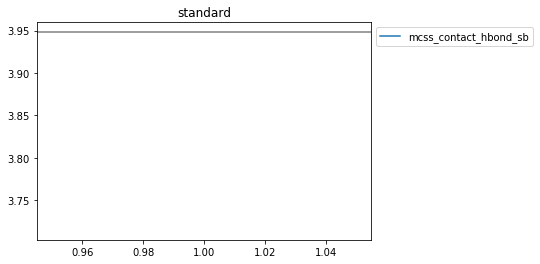

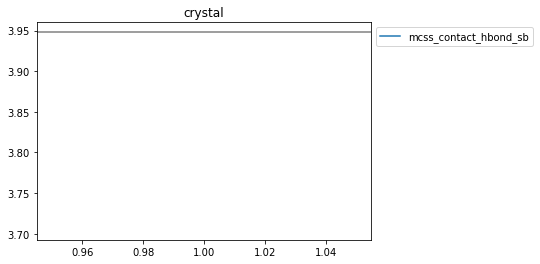

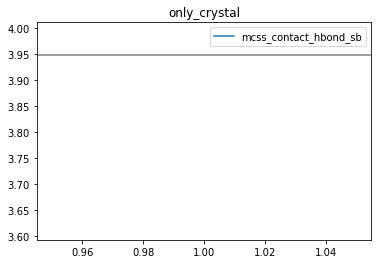

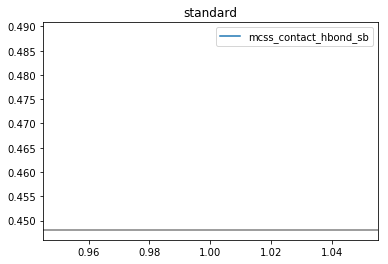

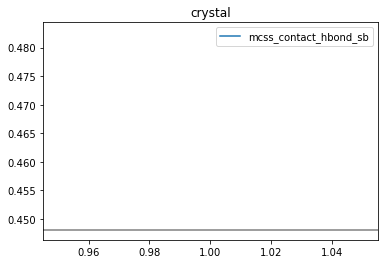

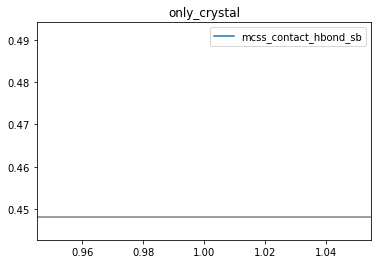

In [3]:
def sweep(data, mode, thresh = None):
    def metric(x):
        if thresh is None:
            return np.mean(x)
        return np.mean(np.array(x) <= thresh)
    
    alpha_factors = sorted(set(k[1] for k in data[mode].keys()))
    features = sorted(set(k[2] for k in data[mode].keys()))
    for feature in features:
        performances = []
        for alpha_factor in alpha_factors:
            performances += [ligand_level_performance(data[mode][(0, alpha_factor, feature)])]
        plt.plot(alpha_factors, [metric(p[1]) for p in performances], label = feature)
        for p in performances:
            plt.axhline(metric(p[0]), c = 'grey')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(mode)
    plt.show()

sweep(data, 'standard')
sweep(data, 'crystal')
sweep(data, 'only_crystal')

thresh = 2.0
sweep(data, 'standard', thresh)
sweep(data, 'crystal', thresh)
sweep(data, 'only_crystal', thresh)

491 valid ligands
Ttest_relResult(statistic=2.9410954127957063, pvalue=0.0034252768526730508)
ComBind improves pose for 90 of 491 ligands
ComBind degrades pose for 50 of 491 ligands
All Ligands RMSD Glide: 3.94795702037, 0.448065173116
All Ligands RMSD ComBind: 3.71518819838, 0.488798370672


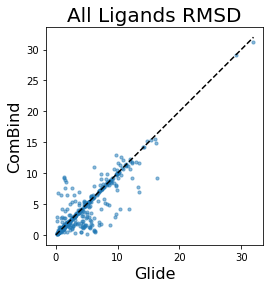

Mean RMSD Glide: 3.8834934983
Mean RMSD ComBind: 3.53538635088


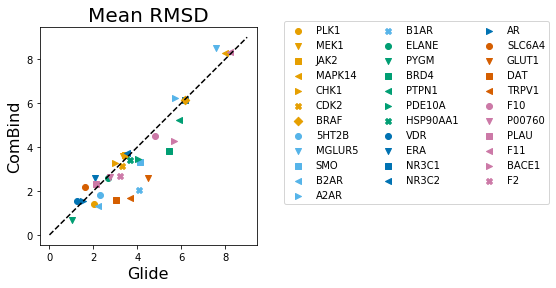

Fraction Near-Native Glide: 0.439011514725
Fraction Near-Native ComBind: 0.521128813516


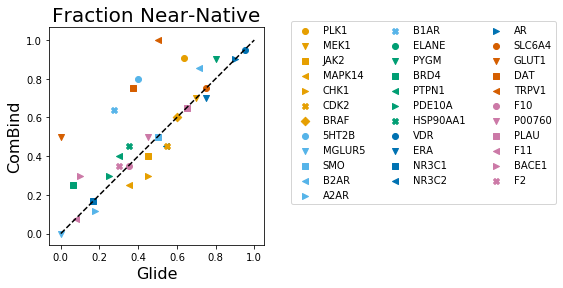

In [4]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')])

281 valid ligands
Ttest_relResult(statistic=4.8651850742741649, pvalue=1.9111893956937244e-06)
ComBind improves pose for 71 of 281 ligands
ComBind degrades pose for 26 of 281 ligands
All Ligands RMSD Glide: 4.06045244652, 0.35231316726
All Ligands RMSD ComBind: 3.55233050681, 0.448398576512


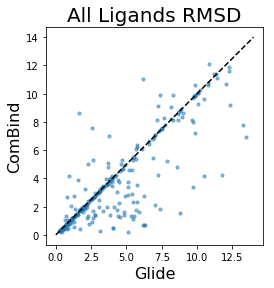

Mean RMSD Glide: 4.01360009387
Mean RMSD ComBind: 3.4189864201


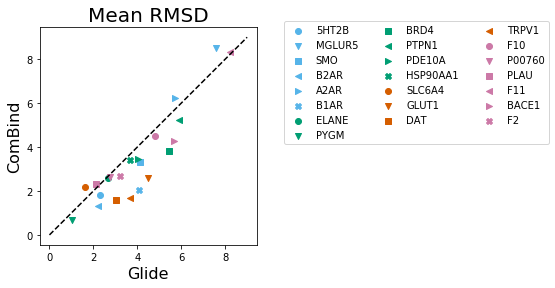

Fraction Near-Native Glide: 0.358086666008
Fraction Near-Native ComBind: 0.49718530133


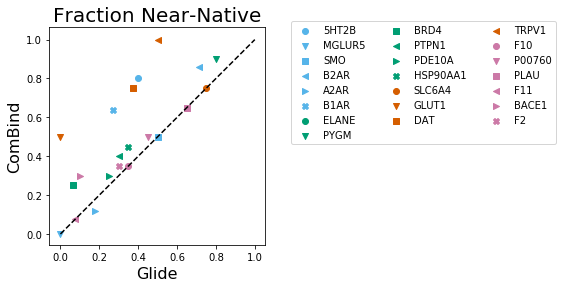

In [5]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR', 'Peptidase', 'Other', 'Transporter'])

360 valid ligands
Ttest_relResult(statistic=3.8512648813015251, pvalue=0.00013913159484485674)
ComBind improves pose for 76 of 360 ligands
ComBind degrades pose for 33 of 360 ligands
All Ligands RMSD Glide: 3.81228878703, 0.419444444444
All Ligands RMSD ComBind: 3.46690743688, 0.488888888889


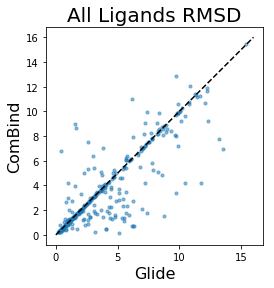

Mean RMSD Glide: 3.80869127057
Mean RMSD ComBind: 3.3620344871


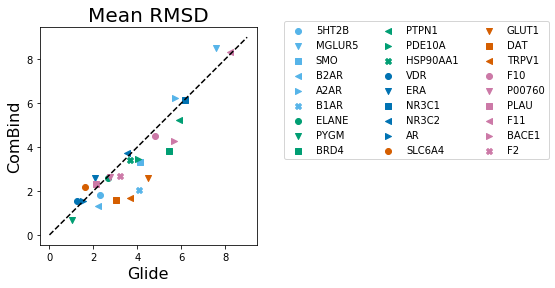

Fraction Near-Native Glide: 0.414445476455
Fraction Near-Native ComBind: 0.522566250017


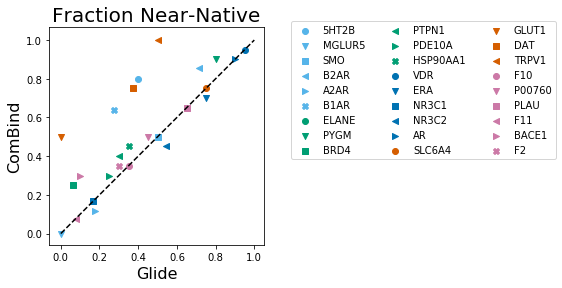

In [6]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')],
          families = ['GPCR', 'Peptidase', 'Other', 'Transporter', 'Nuclear Receptor'])

48 valid ligands
Ttest_relResult(statistic=1.3370995820365947, pvalue=0.18762590761999465)
ComBind improves pose for 13 of 48 ligands
ComBind degrades pose for 10 of 48 ligands
All Ligands RMSD Glide: 4.49016749282, 0.3125
All Ligands RMSD ComBind: 4.03733509225, 0.4375


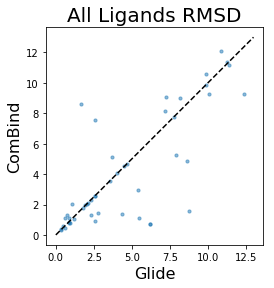

Mean RMSD Glide: 4.33248140911
Mean RMSD ComBind: 3.8718385285


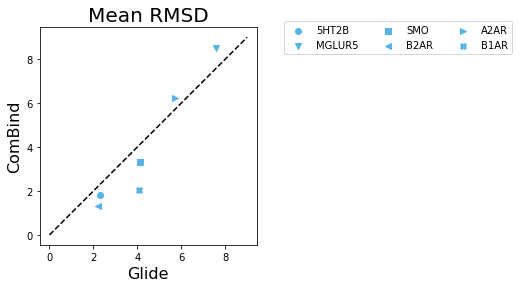

Fraction Near-Native Glide: 0.343913929208
Fraction Near-Native ComBind: 0.485192258722


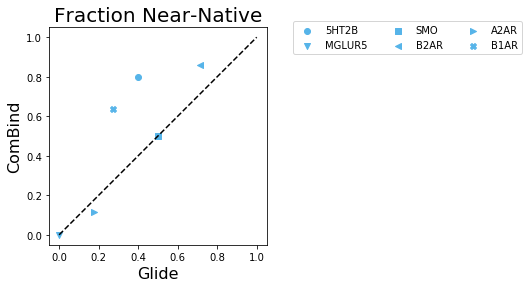

In [7]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], families = ['GPCR'])

131 valid ligands
Ttest_relResult(statistic=-0.47160465337580554, pvalue=0.6379995532033671)
ComBind improves pose for 14 of 131 ligands
ComBind degrades pose for 17 of 131 ligands
All Ligands RMSD Glide: 4.32078575322, 0.526717557252
All Ligands RMSD ComBind: 4.39748647425, 0.488549618321


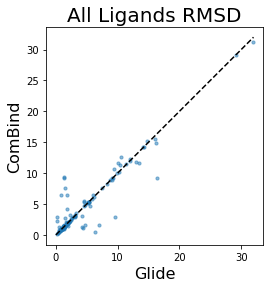

Mean RMSD Glide: 4.17201637667
Mean RMSD ComBind: 4.204029254


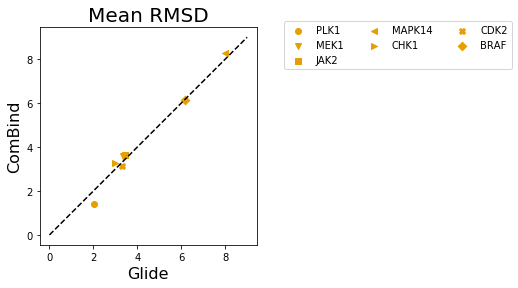

Fraction Near-Native Glide: 0.533766233766
Fraction Near-Native ComBind: 0.515584415584


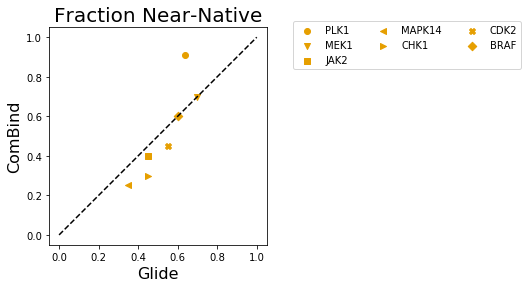

In [8]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], families = ['Kinase'])

79 valid ligands
Ttest_relResult(statistic=-1.5102540443656689, pvalue=0.13501924082698663)
ComBind improves pose for 5 of 79 ligands
ComBind degrades pose for 7 of 79 ligands
All Ligands RMSD Glide: 2.92958007415, 0.658227848101
All Ligands RMSD ComBind: 3.16306082106, 0.632911392405


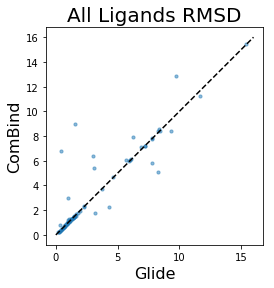

Mean RMSD Glide: 2.90709244807
Mean RMSD ComBind: 3.11144598192


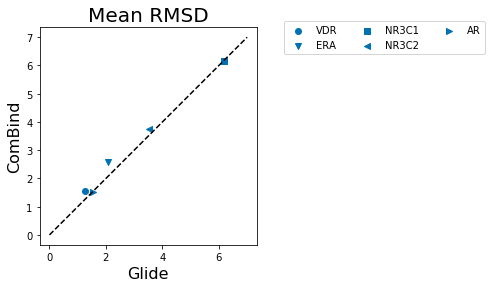

Fraction Near-Native Glide: 0.662424242424
Fraction Near-Native ComBind: 0.634242424242


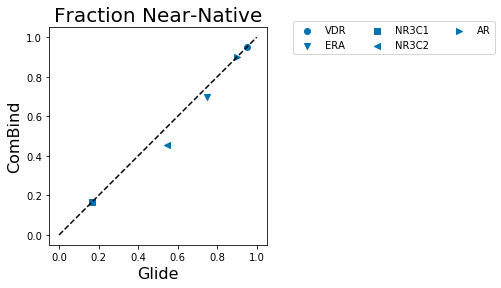

In [9]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], families = ['Nuclear Receptor'])

16 valid ligands
Ttest_relResult(statistic=2.1648861764841358, pvalue=0.04693046201410777)
ComBind improves pose for 6 of 16 ligands
ComBind degrades pose for 1 of 16 ligands
All Ligands RMSD Glide: 2.93689762921, 0.4375
All Ligands RMSD ComBind: 1.8792591108, 0.75


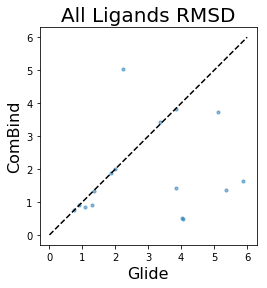

Mean RMSD Glide: 3.20258177129
Mean RMSD ComBind: 2.00838487454


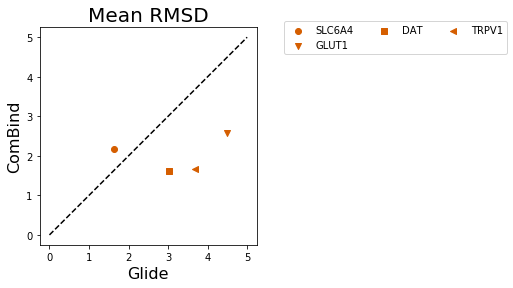

Fraction Near-Native Glide: 0.40625
Fraction Near-Native ComBind: 0.75


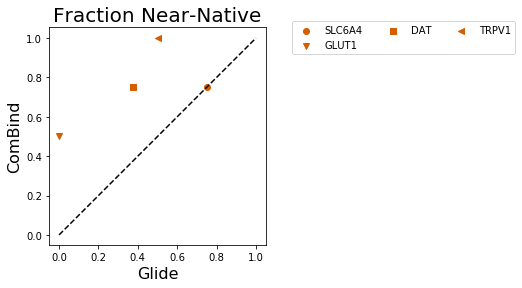

In [10]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], families = ['Transporter'])

113 valid ligands
Ttest_relResult(statistic=2.5555123130749298, pvalue=0.011943766317547391)
ComBind improves pose for 19 of 113 ligands
ComBind degrades pose for 8 of 113 ligands
All Ligands RMSD Glide: 4.23090693666, 0.336283185841
All Ligands RMSD ComBind: 3.86017563411, 0.389380530973


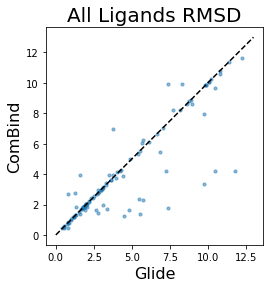

Mean RMSD Glide: 4.46394833265
Mean RMSD ComBind: 4.12059777787


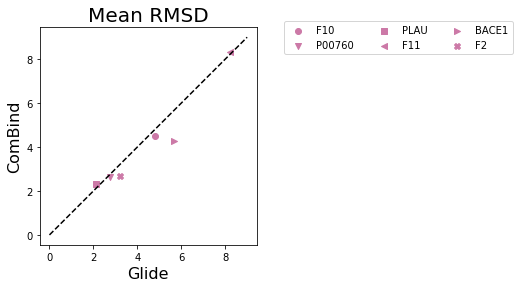

Fraction Near-Native Glide: 0.321153846154
Fraction Near-Native ComBind: 0.371153846154


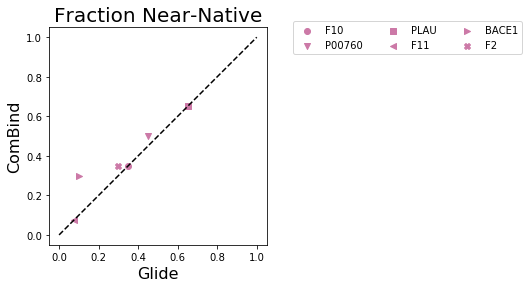

In [11]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], families = ['Peptidase'])

104 valid ligands
Ttest_relResult(statistic=3.7839326132198923, pvalue=0.0002594843887244929)
ComBind improves pose for 33 of 104 ligands
ComBind degrades pose for 7 of 104 ligands
All Ligands RMSD Glide: 3.84977165295, 0.375
All Ligands RMSD ComBind: 3.25139226499, 0.471153846154


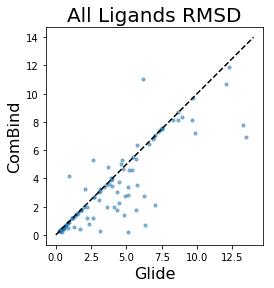

Mean RMSD Glide: 3.78504942157
Mean RMSD ComBind: 3.20492398429


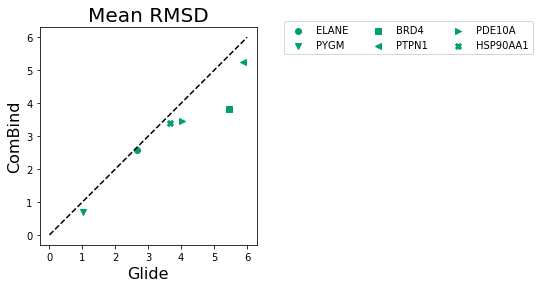

Fraction Near-Native Glide: 0.377083333333
Fraction Near-Native ComBind: 0.466666666667


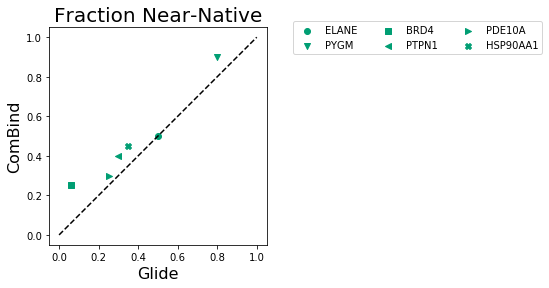

In [12]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], families = ['Other'])

In [13]:
from benchmark import get_mcss_sizes
mcss_sizes = get_mcss_sizes(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')])

ELANE
VDR
5HT2B
SLC6A4
PLK1
MGLUR5
ERA
F10
GLUT1
SMO
DAT
MEK1
JAK2
TRPV1
PYGM
P00760
MAPK14
B2AR
NR3C1
NR3C2
PLAU
AR
BRD4
PTPN1
F11
PDE10A
A2AR
BACE1
F2
CHK1
CDK2
BRAF
HSP90AA1
B1AR


184 valid ligands
Ttest_relResult(statistic=3.2260533496129362, pvalue=0.0014869227200876105)
ComBind improves pose for 35 of 184 ligands
ComBind degrades pose for 12 of 184 ligands
All Ligands RMSD Glide: 2.9431525392, 0.565217391304
All Ligands RMSD ComBind: 2.60446162162, 0.663043478261


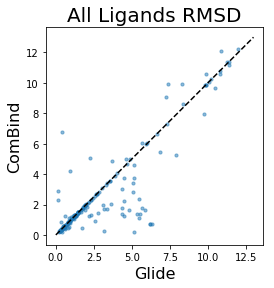

Mean RMSD Glide: 2.76308113307
Mean RMSD ComBind: 2.39573566821


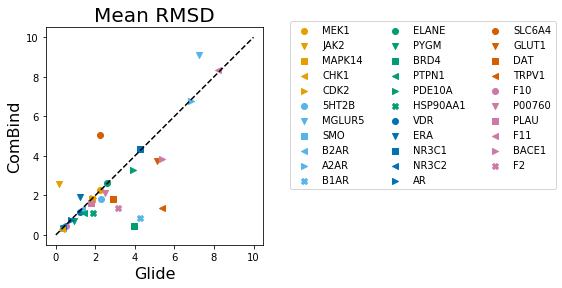

Fraction Near-Native Glide: 0.551392826407
Fraction Near-Native ComBind: 0.661051393782


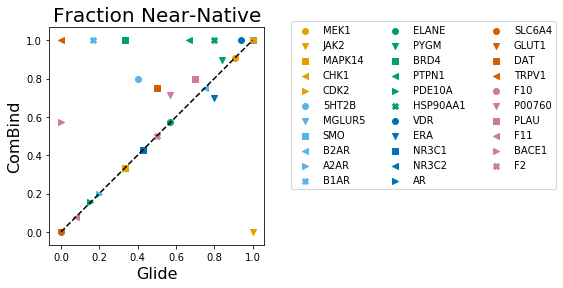

In [14]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], mcss_sizes = mcss_sizes, low = 0.5)

307 valid ligands
Ttest_relResult(statistic=1.5417680675226819, pvalue=0.12416343141999392)
ComBind improves pose for 55 of 307 ligands
ComBind degrades pose for 38 of 307 ligands
All Ligands RMSD Glide: 4.55018511332, 0.377850162866
All Ligands RMSD ComBind: 4.38090054406, 0.384364820847


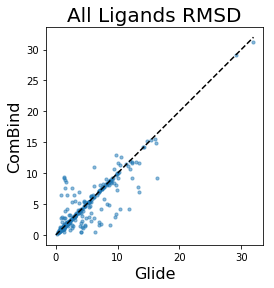

Mean RMSD Glide: 4.14255554666
Mean RMSD ComBind: 3.8688527004


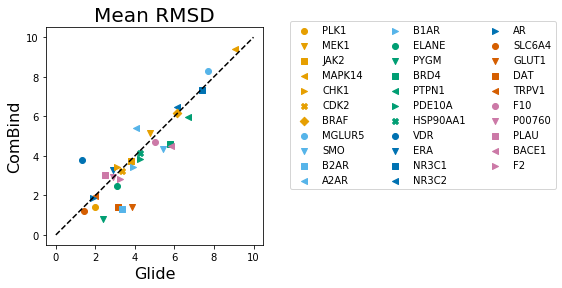

Fraction Near-Native Glide: 0.390080236563
Fraction Near-Native ComBind: 0.460042112708


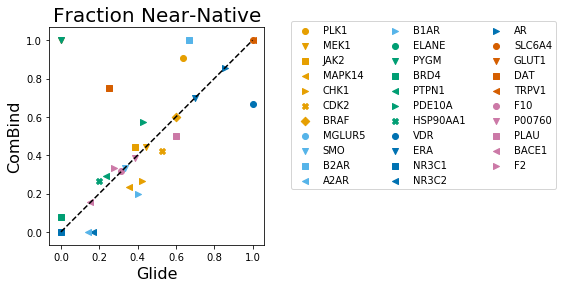

In [15]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], mcss_sizes = mcss_sizes, high = 0.5)

In [16]:
total   = (0.33 * 1.0)  + (0.16 * 1.0)  + (0.03 * 1.0) + (0.03 * 1.0) + (0.07 * 1.0) + (.2 * 1.0)
glide   = (0.33 * 0.34) + (0.16 * 0.66) + (0.03 * .53) + (0.03 * .32) + (0.07 * .40) + (.2 * 0.35)
combind = (0.33 * 0.49) + (0.16 * 0.64) + (0.03 * .51) + (0.03 * .37) + (0.07 * .75) + (.2 * 0.43)

total, glide / total, combind / total, combind / glide

(0.8200000000000001, 0.416219512195122, 0.523170731707317, 1.2569586873718135)

148 valid ligands
Ttest_relResult(statistic=2.9357393475025098, pvalue=0.0038630974324230971)
ComBind improves pose for 26 of 148 ligands
ComBind degrades pose for 9 of 148 ligands
All Ligands RMSD Glide: 2.04933782993, 0.702702702703
All Ligands RMSD ComBind: 1.68725288262, 0.824324324324


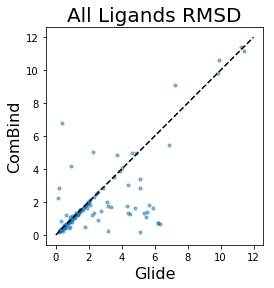

Mean RMSD Glide: 2.17086561331
Mean RMSD ComBind: 1.84130660164


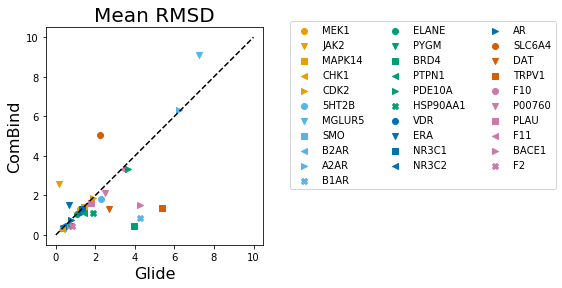

Fraction Near-Native Glide: 0.658365711876
Fraction Near-Native ComBind: 0.787467997952


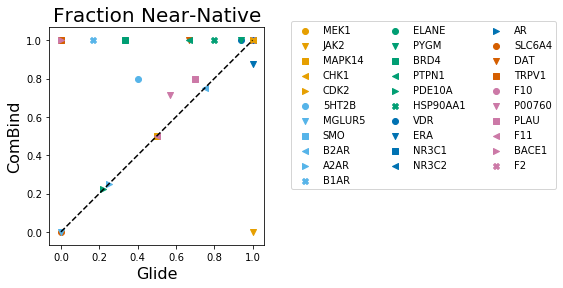

In [17]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], mcss_sizes = mcss_sizes, low = 0.5, correct_only = True)

200 valid ligands
Ttest_relResult(statistic=-0.33245058776896896, pvalue=0.73989897629779833)
ComBind improves pose for 27 of 200 ligands
ComBind degrades pose for 23 of 200 ligands
All Ligands RMSD Glide: 2.60403311857, 0.58
All Ligands RMSD ComBind: 2.64788536676, 0.59


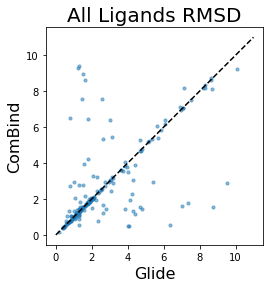

Mean RMSD Glide: 2.68613803082
Mean RMSD ComBind: 2.72471776668


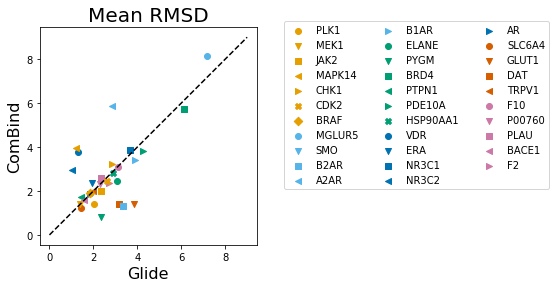

Fraction Near-Native Glide: 0.541412493756
Fraction Near-Native ComBind: 0.581556464369


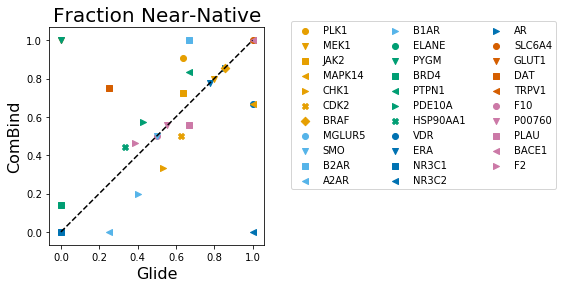

In [18]:
benchmark(data['standard'][(0, 1.0, 'mcss_contact_hbond_sb')], mcss_sizes = mcss_sizes, high = 0.5, correct_only = True)